## 1. Install and Import Dependencies

If dependencies are not installed, run first:
```
pip install diffusers transformers accelerate datasets
```

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Check GPU
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

CUDA available: True
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 25.3 GB


## 2. Download and Load CelebA-HQ Dataset

We load the CelebA-HQ dataset first. This dataset serves as the **Target Distribution** for KSWGD and the **Ground Truth** for LDM's evaluation (FID). By loading it here, we ensure both methods are compared against the same data source.

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'mattymchen/celeba-hq' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Data directory: /workspace/kswgd/data
CelebA-HQ cache directory: /workspace/kswgd/data/CelebA-HQ

Data will be saved to data/CelebA-HQ/ folder
Trying to load: mattymchen/celeba-hq
✓ Successfully loaded: mattymchen/celeba-hq

✓ CelebA-HQ loaded!
  Save location: /workspace/kswgd/data/CelebA-HQ
  Total available samples: 28000

Visualizing first 5 samples (Preview of Target Distribution):


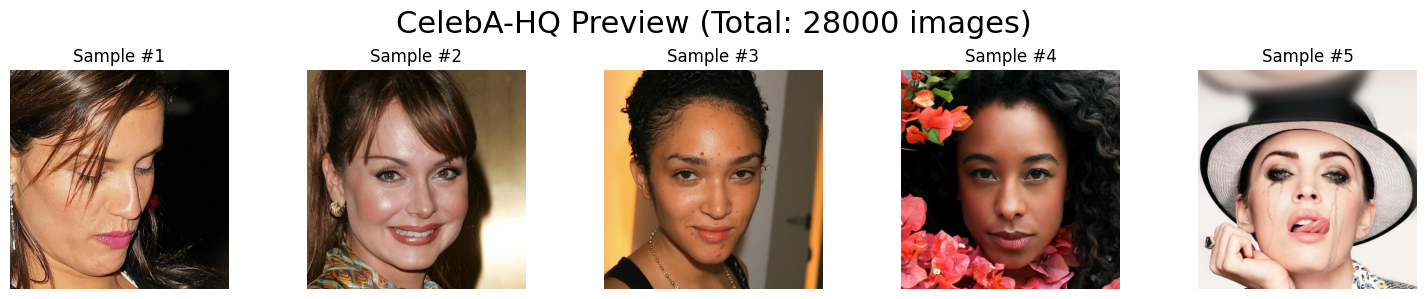

In [2]:
# Download CelebA-HQ to data/ folder
import subprocess
import sys
import os

try:
    from datasets import load_dataset
except ImportError:
    print("Installing datasets library...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "datasets", "-q"])
    from datasets import load_dataset

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# Set data directory (alongside MNIST, CIFAR-10)
DATA_DIR = "/workspace/kswgd/data"
CELEBAHQ_CACHE = os.path.join(DATA_DIR, "CelebA-HQ")
os.makedirs(CELEBAHQ_CACHE, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"CelebA-HQ cache directory: {CELEBAHQ_CACHE}")

# Download CelebA-HQ dataset to data/ folder
# Try multiple possible dataset sources
print("\nDownloading CelebA-HQ dataset...")
print("Data will be saved to data/CelebA-HQ/ folder")

dataset_sources = [
    "mattymchen/celeba-hq",           # Alternative source 1
    "datasets-community/CelebA-HQ",   # Alternative source 2
    "xinrongzhang2022/celeba-hq",     # Alternative source 3
]

celebahq_dataset = None
for source in dataset_sources:
    try:
        print(f"Trying to load: {source}")
        celebahq_dataset = load_dataset(
            source, 
            split="train",
            cache_dir=CELEBAHQ_CACHE,
            trust_remote_code=True
        )
        print(f"✓ Successfully loaded: {source}")
        break
    except Exception as e:
        print(f"✗ Failed to load: {e}")
        continue

if celebahq_dataset is None:
    raise RuntimeError("Unable to load CelebA-HQ dataset, please check network connection or download manually")

print(f"\n✓ CelebA-HQ loaded!")
print(f"  Save location: {CELEBAHQ_CACHE}")
print(f"  Total available samples: {len(celebahq_dataset)}")

# Display a few samples as a preview
import matplotlib.pyplot as plt
n_preview = 5
print(f"\nVisualizing first {n_preview} samples (Preview of Target Distribution):")

fig, axes = plt.subplots(1, n_preview, figsize=(15, 3))
for i in range(n_preview):
    # Try different field names
    if "image" in celebahq_dataset.features:
        img = celebahq_dataset[i]["image"]
    elif "img" in celebahq_dataset.features:
        img = celebahq_dataset[i]["img"]
    else:
        img = celebahq_dataset[i][list(celebahq_dataset.features.keys())[0]]
    axes[i].imshow(img)
    axes[i].set_title(f"Sample #{i+1}")
    axes[i].axis('off')
plt.suptitle(f"CelebA-HQ Preview (Total: {len(celebahq_dataset)} images)", fontsize=22)
plt.tight_layout()
plt.show()

## 3. Load Pretrained Unconditional Latent Diffusion Model

Using `CompVis/ldm-celebahq-256`, an **unconditional** Latent Diffusion Model (LDM) trained on CelebA-HQ.

**LDM Architecture:**
- VAE: Image ↔ Latent Space
- UNet: Denoising in Latent Space (unconditional)

In [3]:
from diffusers import DiffusionPipeline

# Load Unconditional Latent Diffusion Model (LDM)
# This is a true unconditional model working in latent space
print("Loading Unconditional LDM (CompVis/ldm-celebahq-256)...")
print("This is an unconditional Latent Diffusion Model trained on CelebA-HQ")

ldm_pipe = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
ldm_pipe = ldm_pipe.to("cuda")

print("\n✓ Unconditional LDM loaded!")
print(f"  Model: CompVis/ldm-celebahq-256")
print(f"  Output size: 256×256")
print(f"  Latent Space: Yes (VAE)")
print(f"  Generation: Pure unconditional, no condition input required")

Loading Unconditional LDM (CompVis/ldm-celebahq-256)...
This is an unconditional Latent Diffusion Model trained on CelebA-HQ


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae.


✓ Unconditional LDM loaded!
  Model: CompVis/ldm-celebahq-256
  Output size: 256×256
  Latent Space: Yes (VAE)
  Generation: Pure unconditional, no condition input required


## 4. Batch Unconditional LDM Generation

Generating 4 unconditional LDM images (batch_size=16)...
This will take a while...


LDM Generation:   0%|          | 0/1 [00:00<?, ?it/s]


✓ LDM generation complete!
Total images: 4
Total time: 11.7 seconds (0.2 minutes)
Average per image: 2.93 seconds


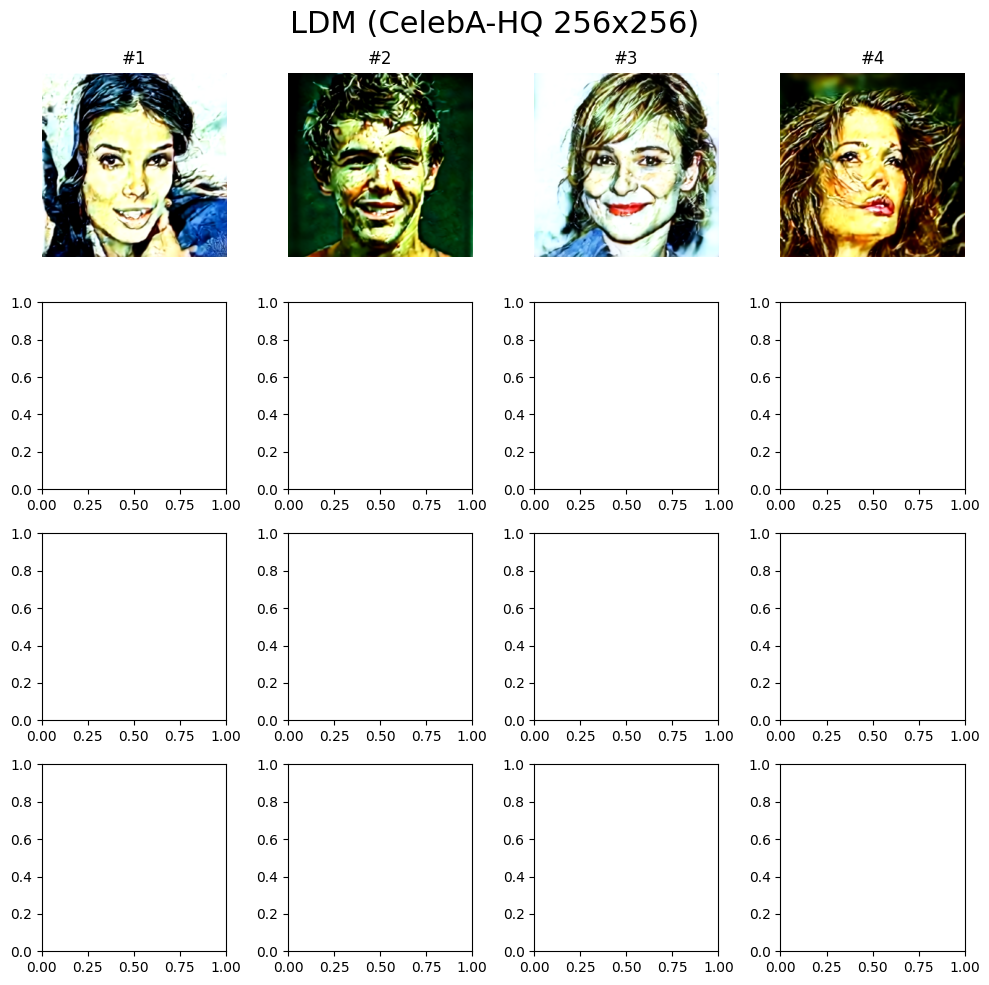

In [4]:
import time
from tqdm.auto import tqdm

# Batch generate multiple unconditional images
n_generate = 4  # Generate 1000 images for quick FID calculation
batch_size = 16    # Generate in batches to avoid OOM

print(f"Generating {n_generate} unconditional LDM images (batch_size={batch_size})...")
print(f"This will take a while...")
start_time = time.time()

# Disable inner progress bar to avoid cluttering the output
ldm_pipe.set_progress_bar_config(disable=True)

ldm_generated_images = []
n_batches = (n_generate + batch_size - 1) // batch_size

for batch_idx in tqdm(range(n_batches), desc="LDM Generation"):
    current_batch_size = min(batch_size, n_generate - batch_idx * batch_size)
    result = ldm_pipe(
        batch_size=current_batch_size,
        num_inference_steps=200,
    )
    ldm_generated_images.extend(result.images)
    
    # Clear cache periodically
    if (batch_idx + 1) % 50 == 0:
        torch.cuda.empty_cache()

elapsed = time.time() - start_time
print(f"\n✓ LDM generation complete!")
print(f"Total images: {len(ldm_generated_images)}")
print(f"Total time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
print(f"Average per image: {elapsed/len(ldm_generated_images):.2f} seconds")

# Visualization (show first 16)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for idx in range(min(16, len(ldm_generated_images))):
    axes[idx].imshow(ldm_generated_images[idx])
    axes[idx].set_title(f"#{idx+1}")
    axes[idx].axis('off')

plt.suptitle(f"LDM (CelebA-HQ 256x256)", fontsize=22)
plt.tight_layout()
plt.show()

## 4.1 Super-Resolution (Real-ESRGAN)

The native output of LDM is 256x256. To match the visual quality of high-resolution papers, we apply **Real-ESRGAN** super-resolution to upscale images to 1024x1024.

This is **Method A** - the same approach used in many diffusion model papers for high-quality output.

Initializing Real-ESRGAN upscaler...


/workspace/kswgd_env/lib/python3.11/site-packages/realesrgan/utils.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path, map_location=torch.d

Initializing GFPGAN face enhancer...


/workspace/kswgd_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/kswgd_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/workspace/kswgd_env/lib/python3.11/site-packages/facexlib/detection/__init__.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

✓ Upscalers initialized!
  - Real-ESRGAN: 4x basic upscale
  - GFPGAN: 4x upscale + face enhancement + color correction
  - Preprocessing: Gaussian blur + Bilateral filter + Color normalization

Upscaling LDM Generated Images with GFPGAN
(with preprocessing: Gaussian + Bilateral + Color Norm)

Enhancing 4 LDM images with preprocessing + GFPGAN...


Preprocess+GFPGAN:   0%|          | 0/4 [00:00<?, ?it/s]

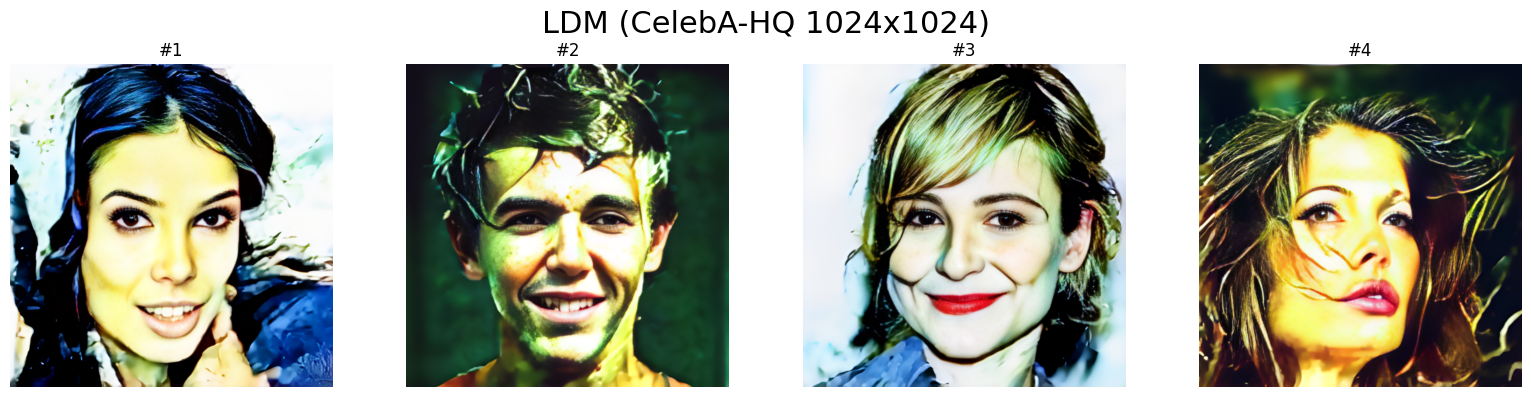


✓ Enhancement complete!
  Original LDM: 256x256
  Enhanced: 1024x1024
  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)


In [5]:
# Real-ESRGAN + GFPGAN Super-Resolution Setup
import os
import cv2
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from gfpgan import GFPGANer

# Create figures directory if not exists
os.makedirs('/workspace/kswgd/figures', exist_ok=True)

# Initialize Real-ESRGAN (basic upscaler)
model_path = '/workspace/kswgd/weights/RealESRGAN_x4plus.pth'
print("Initializing Real-ESRGAN upscaler...")

model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
upsampler = RealESRGANer(
    scale=4,
    model_path=model_path,
    model=model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=True,
    gpu_id=0
)

# Initialize GFPGAN (face enhancement + upscaling)
print("Initializing GFPGAN face enhancer...")
face_enhancer = GFPGANer(
    model_path='/workspace/kswgd/weights/GFPGANv1.3.pth',
    upscale=4,
    arch='clean',
    channel_multiplier=2,
    bg_upsampler=upsampler  # Use Real-ESRGAN for background
)

def preprocess_image(img_bgr, use_gaussian=True, use_bilateral=True, use_color_norm=True):
    """
    Apply preprocessing before GFPGAN:
    1. Gaussian blur - reduce noise
    2. Bilateral filter - edge-preserving smoothing
    3. Color normalization - adjust color distribution (mean normalization)
    """
    processed = img_bgr.copy().astype(np.float32)
    
    # 1. Gaussian Blur (slight smoothing, small kernel size)
    if use_gaussian:
        # Use small kernel (3x3) and small sigma for slight denoising
        processed = cv2.GaussianBlur(processed, (3, 3), sigmaX=0.5)
    
    # 2. Bilateral Filter (edge-preserving smoothing)
    if use_bilateral:
        # d=5: filter diameter, sigmaColor=30: color space sigma, sigmaSpace=30: coordinate space sigma
        # Smaller values preserve more details
        processed = cv2.bilateralFilter(processed.astype(np.uint8), d=5, sigmaColor=30, sigmaSpace=30).astype(np.float32)
    
    # 3. Color Normalization (color space mean normalization)
    if use_color_norm:
        # Calculate the mean of each channel
        mean_b = np.mean(processed[:, :, 0])
        mean_g = np.mean(processed[:, :, 1])
        mean_r = np.mean(processed[:, :, 2])
        
        # Target mean (typical face image mean for CelebA-HQ, warm tones)
        target_mean = 127.5  # Neutral gray
        
        # Adjust each channel to the target mean
        # Use a gentle adjustment coefficient to avoid excessive changes
        alpha = 0.3  # Adjustment intensity (0=no adjustment, 1=full adjustment to target)
        
        processed[:, :, 0] = processed[:, :, 0] + alpha * (target_mean - mean_b)
        processed[:, :, 1] = processed[:, :, 1] + alpha * (target_mean - mean_g)
        processed[:, :, 2] = processed[:, :, 2] + alpha * (target_mean - mean_r)
        
        # Clip to valid range
        processed = np.clip(processed, 0, 255)
    
    return processed.astype(np.uint8)

def upscale_images(images_list, use_face_enhance=True, use_preprocess=True, desc="Upscaling"):
    """
    Upscale images using GFPGAN (face enhancement) or Real-ESRGAN (basic upscale).
    
    Args:
        images_list: list of images (PIL or numpy)
        use_face_enhance: use GFPGAN for face enhancement
        use_preprocess: apply preprocessing (Gaussian, Bilateral, Color norm) before GFPGAN
        desc: progress bar description
    """
    upscaled_images = []
    
    for img in tqdm(images_list, desc=desc):
        if isinstance(img, Image.Image):
            img_np = np.array(img)
        else:
            if img.ndim == 3 and img.shape[0] == 3:
                img_np = np.transpose(img, (1, 2, 0))
            else:
                img_np = img
            if img_np.max() <= 1.0:
                img_np = (img_np * 255).astype(np.uint8)
        
        # Convert RGB to BGR for OpenCV-based models
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        
        # Apply preprocessing before GFPGAN
        if use_preprocess:
            img_bgr = preprocess_image(
                img_bgr, 
                use_gaussian=True,      # Gaussian blur
                use_bilateral=True,     # Bilateral filter
                use_color_norm=True     # Color normalization
            )
        
        if use_face_enhance:
            # GFPGAN: face enhancement + color correction
            _, _, output_bgr = face_enhancer.enhance(img_bgr, has_aligned=False, only_center_face=False, paste_back=True)
        else:
            # Real-ESRGAN: basic upscale only
            output_bgr, _ = upsampler.enhance(img_bgr, outscale=4)
        
        # Convert BGR back to RGB
        output_rgb = cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)
        upscaled_images.append(output_rgb)
        
    return upscaled_images

print("✓ Upscalers initialized!")
print(f"  - Real-ESRGAN: 4x basic upscale")
print(f"  - GFPGAN: 4x upscale + face enhancement + color correction")
print(f"  - Preprocessing: Gaussian blur + Bilateral filter + Color normalization")

# ============== Upscale LDM Generated Images ==============
print("\n" + "=" * 60)
print("Upscaling LDM Generated Images with GFPGAN")
print("(with preprocessing: Gaussian + Bilateral + Color Norm)")
print("=" * 60)

# Use all generated images from previous cell
n_test = len(ldm_generated_images)
print(f"\nEnhancing {n_test} LDM images with preprocessing + GFPGAN...")
ldm_enhanced = upscale_images(ldm_generated_images, use_face_enhance=True, use_preprocess=True, desc="Preprocess+GFPGAN")

# Visualization (show up to 16 in a grid)
n_show = min(16, n_test)
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.asarray(axes).reshape(-1)

for i in range(n_show):
    axes[i].imshow(ldm_enhanced[i])
    axes[i].set_title(f"#{i+1}")
    axes[i].axis('off')

for i in range(n_show, len(axes)):
    axes[i].axis('off')

plt.suptitle("LDM (CelebA-HQ 1024x1024)", fontsize=22)
plt.tight_layout()
plt.savefig('/workspace/kswgd/figures/ldm_gfpgan_enhanced.png', dpi=150, bbox_inches='tight')
plt.show()

# Store enhanced images for later use
ldm_upscaled = ldm_enhanced

print(f"\n✓ Enhancement complete!")
print(f"  Original LDM: 256x256")
print(f"  Enhanced: {ldm_upscaled[0].shape[1]}x{ldm_upscaled[0].shape[0]}")
print(f"  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)")

## 5. Extract LDM's VAE (for KSWGD)

Directly use LDM's built-in VAE to maintain consistent latent space.

In [6]:
# Directly use LDM's built-in VAE
# This way KSWGD and LDM use exactly the same latent space

print("Extracting LDM's VAE...")

# LDM pipeline contains vqvae (VQ-VAE)
vae = ldm_pipe.vqvae
vae_scaling = 1.0  # LDM's VQ-VAE doesn't need extra scaling

print(f"\n✓ VAE extracted!")
print(f"  Source: LDM's built-in VQ-VAE")
print(f"  Scaling factor: {vae_scaling}")
print(f"  Advantage: KSWGD and LDM share the same latent space")

# VAE helper functions
def _to_vae_range(x):
    """[0,1] → [-1,1]"""
    return (x * 2.0) - 1.0

def _from_vae_range(x):
    """[-1,1] → [0,1]"""
    return torch.clamp((x + 1.0) * 0.5, 0.0, 1.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Extracting LDM's VAE...

✓ VAE extracted!
  Source: LDM's built-in VQ-VAE
  Scaling factor: 1.0
  Advantage: KSWGD and LDM share the same latent space


### 5.1 VAE Reconstruction Test

To verify that LDM's VAE can accurately represent the CelebA-HQ images, we perform a reconstruction test on the real images loaded in Section 2. This demonstrates LDM's "understanding" of the data distribution.

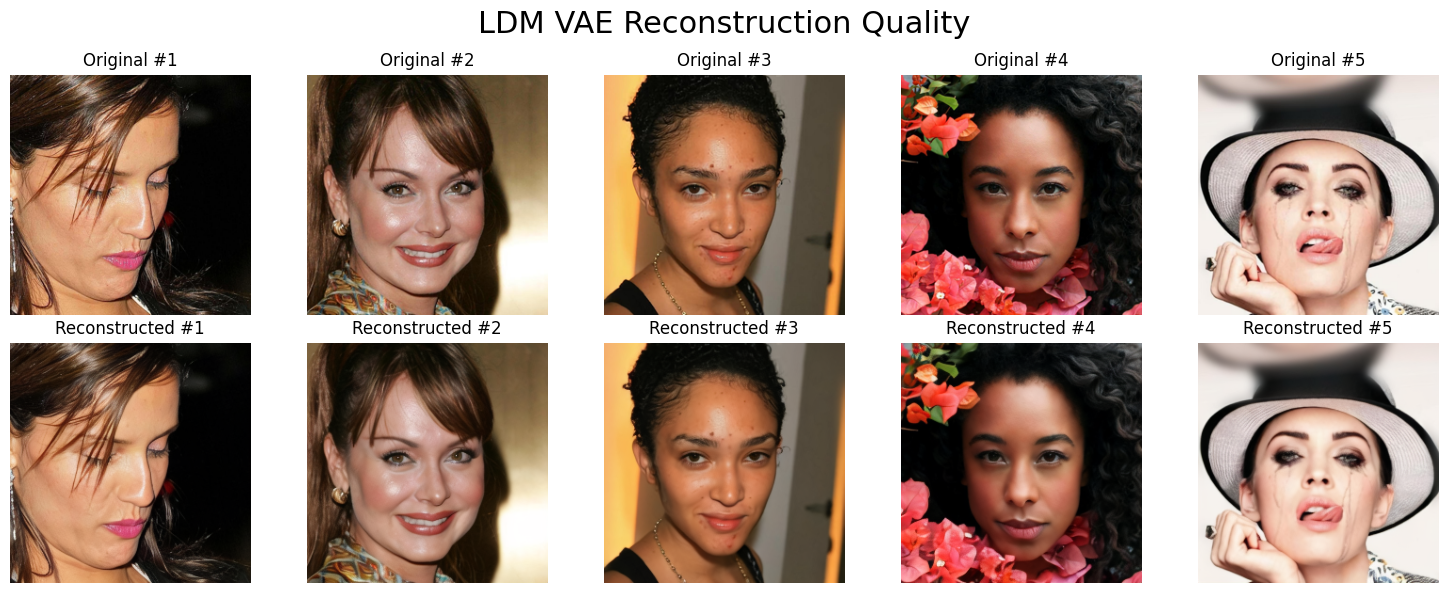

In [7]:
# Test VAE reconstruction on real images
n_recon = 5
fig, axes = plt.subplots(2, n_recon, figsize=(15, 6))

vae.eval()
with torch.no_grad():
    for i in range(n_recon):
        # Original
        img = celebahq_dataset[i]["image"]
        img_tensor = T.Compose([T.Resize((256, 256)), T.ToTensor()])(img).unsqueeze(0).to(device)
        
        # Encode & Decode
        latent = vae.encode(_to_vae_range(img_tensor))
        
        if hasattr(latent, 'latents'):
            latent_code = latent.latents
        elif hasattr(latent, 'latent_dist'):
            latent_code = latent.latent_dist.mode()
        else:
            latent_code = latent[0] if isinstance(latent, tuple) else latent
            
        recon = vae.decode(latent_code).sample
        recon_img = _from_vae_range(recon).cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        # Plot
        axes[0, i].imshow(np.array(img.resize((256, 256))))
        axes[0, i].set_title(f"Original #{i+1}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(recon_img)
        axes[1, i].set_title(f"Reconstructed #{i+1}")
        axes[1, i].axis('off')

plt.suptitle("LDM VAE Reconstruction Quality", fontsize=22)
plt.tight_layout()
plt.show()

## 7. KSWGD Unconditional Generation (Core Experiment)

Using KSWGD (Koopman Spectral Wasserstein Gradient Descent) to perform **unconditional** particle transport generation in latent space.

**Unconditional Pipeline:**
```
Training Data (CelebA-HQ) → VAE Encoder → Latent Z_tar (Target Distribution Samples)
                                              ↓
Random Noise N(0,1) → KSWGD Transport → Z_gen (Unconditional Generation)
                                              ↓
                                   VAE Decoder → Generated Image
```

**Comparison of Two Unconditional Methods (Fair Comparison, Same Dataset):**
| | LDM (Section 2-4) | KSWGD (Section 7) |
|---|---|---|
| Dataset | CelebA-HQ | CelebA-HQ |
| Generation Process | Random Noise → Denoising | Random Noise → KSWGD |
| Core Component | UNet | Kernel Matrix + Eigendecomposition |
| Condition Input | None | None |
| Iteration Steps | 200 | Adjustable (e.g., 300) |

In [8]:
# Import KSWGD required libraries and custom kernel functions
from sklearn.metrics import pairwise_distances
from tqdm.auto import trange

# Import your kernel functions
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

# Try to import GPU version
try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_KSWGD = True
    print("✓ GPU KSWGD backend available (CuPy)")
except Exception as e:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_KSWGD = False
    print(f"✗ GPU KSWGD backend not available: {e}")
    print("  Using CPU backend instead")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

✓ GPU KSWGD backend available (CuPy)
Device: cuda


In [20]:
# Encode CelebA-HQ images and apply PCA dimensionality reduction
from sklearn.decomposition import IncrementalPCA
from torchvision import transforms as T
from tqdm.auto import tqdm

# Image preprocessing
transform_celebahq = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

# ============== Dimensionality Reduction Settings ==============
# VQ-VAE latent is (4, 16, 16) = 1024 dims
REDUCED_DIM = 64  # Reduce 1024 -> 64 using PCA
# ===============================================================

max_samples = 2000 
all_latents = []

vae.eval()
print(f"Encoding {max_samples} images to latent space...")

with torch.no_grad():
    for i in tqdm(range(min(max_samples, len(celebahq_dataset))), desc="Encoding"):
        img = celebahq_dataset[i]["image"]
        img_tensor = transform_celebahq(img).unsqueeze(0).to(device)
        
        # Encode to latent
        latent = vae.encode(_to_vae_range(img_tensor))
        latent_code = latent.latents if hasattr(latent, 'latents') else (latent.latent_dist.mode() if hasattr(latent, 'latent_dist') else latent[0])
        latent_code = latent_code * vae_scaling # (1, 4, 16, 16)
        
        all_latents.append(latent_code.view(1, -1).cpu().numpy())

Z_flat = np.concatenate(all_latents, axis=0)
print(f"Latent vectors collected: {Z_flat.shape}")

# Apply PCA
print(f"Applying PCA (1024 -> {REDUCED_DIM})...")
pca = IncrementalPCA(n_components=REDUCED_DIM, batch_size=256)
Z_all = pca.fit_transform(Z_flat)
latent_dim = Z_all.shape[1]

print(f"\n✓ PCA complete!")
print(f"  Original latent shape: {Z_flat.shape[1]}")
print(f"  Reduced latent shape:  {Z_all.shape[1]}")
print(f"  Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

# Record shapes for decoding
with torch.no_grad():
    dummy = torch.zeros(1, 3, 256, 256, device=device)
    dummy_latent = vae.encode(_to_vae_range(dummy))
    dummy_code = dummy_latent.latents if hasattr(dummy_latent, 'latents') else (dummy_latent.latent_dist.mode() if hasattr(dummy_latent, 'latent_dist') else dummy_latent[0])
    full_latent_shape = dummy_code.shape[1:] # (4, 16, 16)

print(f"Full Latent Shape: {full_latent_shape}")

Encoding 2000 images to latent space...


Encoding:   0%|          | 0/2000 [00:00<?, ?it/s]

Latent vectors collected: (2000, 12288)
Applying PCA (1024 -> 64)...

✓ PCA complete!
  Original latent shape: 12288
  Reduced latent shape:  64
  Explained variance ratio: 0.3721
Full Latent Shape: torch.Size([3, 64, 64])


### 7.1 Latent Space Dimensionality Reduction: PCA

We use **PCA (Principal Component Analysis)** to reduce the dimensionality of the VQ-VAE latent space from 1024 (4x16x16) to 64.

**Why PCA?**
1.  **Efficiency**: KSWGD's kernel matrix and eigendecomposition scale with the dimensionality of the particles. Reducing to 64 dimensions significantly speeds up the transport process.
2.  **Noise Reduction**: PCA captures the most significant variations in the latent space, effectively filtering out high-frequency noise.
3.  **Reversibility**: We can use `pca.inverse_transform` to project the generated particles back into the 1024-dimensional space before decoding them with the VAE.

In [21]:
# Standardize latent codes and build KSWGD kernel operator
# Standardization
Z_mean = np.mean(Z_all, axis=0, keepdims=True)
Z_std = np.std(Z_all, axis=0, keepdims=True) + 1e-8
Z_std = Z_std.astype(np.float64)
Z_mean = Z_mean.astype(np.float64)
X_tar = ((Z_all - Z_mean) / Z_std).astype(np.float64)

print(f"After standardization: mean={X_tar.mean():.4f}, std={X_tar.std():.4f}")

# Compute squared sum of target samples (for kernel function)
sq_tar = np.sum(X_tar ** 2, axis=1)

# Compute pairwise distances and bandwidth epsilon
dists = pairwise_distances(X_tar, metric="euclidean")
eps_kswgd = np.median(dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_kswgd = float(max(eps_kswgd, 1e-6))

print(f"KSWGD epsilon: {eps_kswgd:.6f}")
print(f"Distance stats: min={dists[dists>0].min():.4f}, median={np.median(dists):.4f}, max={dists.max():.4f}")

# Build data kernel matrix
data_kernel = np.exp(-dists**2 / (2.0 * eps_kswgd))

# Normalization
p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
rw_kernel = np.nan_to_num(rw_kernel)

print(f"Kernel matrix built, shape: {rw_kernel.shape}")

# latent_dim is already set in the previous cell (Spatial Mean Pooling)
print(f"KSWGD latent_dim: {latent_dim}")

After standardization: mean=-0.0000, std=1.0000
KSWGD epsilon: 8.095176


Distance stats: min=0.0000, median=11.0937, max=21.7377
Kernel matrix built, shape: (2000, 2000)
KSWGD latent_dim: 64


In [22]:
# Compute eigendecomposition and KSWGD weights
import time

print("Computing eigendecomposition (may take 1-2 minutes)...")
start_time = time.time()

# Use GPU acceleration for eigendecomposition (if available)
if torch.cuda.is_available():
    print("  Using GPU acceleration...")
    rw_kernel_torch = torch.from_numpy(rw_kernel).to(device)
    lambda_ns_torch, phi_torch = torch.linalg.eigh(rw_kernel_torch)
    lambda_ns = lambda_ns_torch.cpu().numpy()[::-1].copy()
    phi = phi_torch.cpu().numpy()[:, ::-1].copy()
    del rw_kernel_torch, lambda_ns_torch, phi_torch
    torch.cuda.empty_cache()
else:
    print("  Using CPU...")
    lambda_ns, phi = np.linalg.eigh(rw_kernel)
    phi = phi[:, ::-1]
    lambda_ns = lambda_ns[::-1]

elapsed = time.time() - start_time
print(f"Eigendecomposition complete, time: {elapsed:.1f}s")

# Set regularization parameters
tol = 1e-6
reg = 1e-3
latent_dim = X_tar.shape[1]

# Compute inverse eigenvalues (fix negative number issue)
lambda_ = lambda_ns - 1.0
inv_lambda = np.zeros_like(lambda_)
# Only compute inverse for positive lambda_, set negative to 0
positive_mask = lambda_[1:] > tol
inv_lambda[1:][positive_mask] = 1.0 / (np.abs(lambda_[1:][positive_mask]) + reg)
inv_lambda *= eps_kswgd

# Truncate small eigenvalues
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_kswgd / (lambda_ns[mask] + reg)
above_tol = int(np.sum(mask))
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

# Clean NaN and Inf
lambda_ns_s_ns = np.nan_to_num(lambda_ns_s_ns, nan=0.0, posinf=0.0, neginf=0.0)

# Target distribution weights
p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print(f"Number of retained eigenvectors: {above_tol}")
print(f"Top 10 eigenvalues: {lambda_ns[:10]}")
print(f"lambda_ns_s_ns stats: min={lambda_ns_s_ns.min():.6f}, max={lambda_ns_s_ns.max():.6f}, non-zero count={np.sum(lambda_ns_s_ns != 0)}")

Computing eigendecomposition (may take 1-2 minutes)...
  Using GPU acceleration...
Eigendecomposition complete, time: 0.2s
Number of retained eigenvectors: 1999
Top 10 eigenvalues: [1.00614649 0.99996483 0.99988354 0.99971107 0.99817557 0.99789367
 0.99772686 0.99731221 0.99702188 0.99649382]
lambda_ns_s_ns stats: min=0.000000, max=0.000000, non-zero count=0


In [23]:
# Define KSWGD sampler and PCA-based Decoder
def run_kswgd_sampler(num_particles=16, num_iters=200, step_size=0.05, rng_seed=42):
    """
    KSWGD Particle Transport Sampler
    """
    rng = np.random.default_rng(rng_seed)
    use_gpu = GPU_KSWGD and torch.cuda.is_available()
    xp = cp if use_gpu else np
    grad_fn = grad_ker1_gpu if use_gpu else grad_ker1
    K_eval_fn = K_tar_eval_gpu if use_gpu else K_tar_eval
    
    print(f"KSWGD backend: {'GPU (CuPy)' if use_gpu else 'CPU (NumPy)'}")
    
    x_hist = xp.zeros((num_particles, latent_dim, num_iters), dtype=xp.float64)
    init_particles = rng.normal(0.0, 1.0, size=(num_particles, latent_dim))
    x_hist[:, :, 0] = xp.asarray(init_particles)
    
    if use_gpu:
        X_tar_dev, p_tar_dev, sq_tar_dev = cp.asarray(X_tar), cp.asarray(p_tar), cp.asarray(sq_tar)
        D_vec_dev, phi_trunc_dev, lambda_weights = cp.asarray(D_vec), cp.asarray(phi_trunc), cp.asarray(lambda_ns_s_ns)
    else:
        X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, phi_trunc_dev, lambda_weights = X_tar, p_tar, sq_tar, D_vec, phi_trunc, lambda_ns_s_ns
    
    iterator = trange(num_iters - 1, desc="KSWGD Transport", unit="step")
    for t in iterator:
        current = x_hist[:, :, t]
        grad_matrix = grad_fn(current, X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        cross_matrix = K_eval_fn(X_tar_dev, current, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        
        tmp = (phi_trunc_dev.T @ cross_matrix) * lambda_weights[:, None]
        kswgd_push = phi_trunc_dev @ tmp
        
        for dim in range(latent_dim):
            sum_term = grad_matrix[:, :, dim] @ kswgd_push
            x_hist[:, dim, t + 1] = x_hist[:, dim, t] - (step_size / num_particles) * xp.sum(sum_term, axis=1)
        
        if (t + 1) % 50 == 0:
            step_norm = x_hist[:, :, t + 1] - x_hist[:, :, t]
            mean_disp = float(xp.mean(xp.linalg.norm(step_norm, axis=1)))
            iterator.set_postfix({"mean_step": f"{mean_disp:.3e}"})
            if bool(xp.any(xp.isnan(x_hist[:, :, t + 1]))):
                print(f"\nWarning: NaN detected at step {t+1}")
                return np.asarray(xp.asnumpy(x_hist[:, :, t]) if use_gpu else x_hist[:, :, t], dtype=np.float64)
    
    return np.asarray(xp.asnumpy(x_hist[:, :, -1]) if use_gpu else x_hist[:, :, -1], dtype=np.float64)


def decode_latents_to_images(flat_latents_std):
    """Decode standardized PCA latent vectors to images"""
    # 1. De-standardize
    flat_latents = flat_latents_std * Z_std + Z_mean
    
    # 2. PCA Inverse Transform (64 -> 1024)
    latents_recovered = pca.inverse_transform(flat_latents)
    
    # 3. Reshape to (N, 4, 16, 16)
    latents_tensor = torch.from_numpy(latents_recovered).float().view(-1, *full_latent_shape).to(device)
    
    # 4. VAE decode
    vae.eval()
    with torch.no_grad():
        decoded = vae.decode(latents_tensor / vae_scaling).sample
        decoded_rgb = _from_vae_range(decoded)
    
    return decoded_rgb.cpu()

print("KSWGD sampler and PCA Decoder defined!")

KSWGD sampler and PCA Decoder defined!


### 7.1 Run KSWGD Generation

In [24]:
# Run KSWGD sampling to generate new latent vectors
kswgd_config = {
    "num_particles": n_generate,  # (n_generate) Same as LDM generation count for fair comparison
    "num_iters": 300,             # Number of iterations
    "step_size": 0.03,            # Step size (smaller for stability)
    "rng_seed": 42
}

print("=" * 50)
print("KSWGD Generation Config:")
for k, v in kswgd_config.items():
    print(f"  {k}: {v}")
print("=" * 50)
print(f"\nNote: Generating {kswgd_config['num_particles']} particles for reliable FID...")
print("This will take a while...")

# Run KSWGD (progress bar is built into run_kswgd_sampler via trange)
start_time = time.time()
Z_kswgd_std = run_kswgd_sampler(**kswgd_config)
kswgd_time = time.time() - start_time

print(f"\n✓ KSWGD Complete!")
print(f"Generated samples shape: {Z_kswgd_std.shape}")
print(f"Total time: {kswgd_time:.1f} seconds ({kswgd_time/60:.1f} minutes)")

KSWGD Generation Config:
  num_particles: 4
  num_iters: 300
  step_size: 0.03
  rng_seed: 42

Note: Generating 4 particles for reliable FID...
This will take a while...
KSWGD backend: GPU (CuPy)


KSWGD Transport:   0%|          | 0/299 [00:00<?, ?step/s]


✓ KSWGD Complete!
Generated samples shape: (4, 64)
Total time: 12.8 seconds (0.2 minutes)


In [25]:
# Decode KSWGD generated latent vectors to images (in batches to avoid OOM)
print(f"Decoding {Z_kswgd_std.shape[0]} latent vectors to images...")

decode_batch_size = 64
all_kswgd_images = []

for i in tqdm(range(0, Z_kswgd_std.shape[0], decode_batch_size), desc="Decoding KSWGD"):
    batch_latents = Z_kswgd_std[i:i+decode_batch_size]
    batch_images = decode_latents_to_images(batch_latents)
    all_kswgd_images.append(batch_images.numpy())
    
    # Clear cache periodically
    if (i // decode_batch_size + 1) % 20 == 0:
        torch.cuda.empty_cache()

kswgd_images_np = np.concatenate(all_kswgd_images, axis=0)

print(f"\n✓ Decoding complete!")
print(f"Generated images shape: {kswgd_images_np.shape}")
print(f"Pixel value range: [{kswgd_images_np.min():.3f}, {kswgd_images_np.max():.3f}]")

Decoding 4 latent vectors to images...


Decoding KSWGD:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Decoding complete!
Generated images shape: (4, 3, 256, 256)
Pixel value range: [0.000, 1.000]


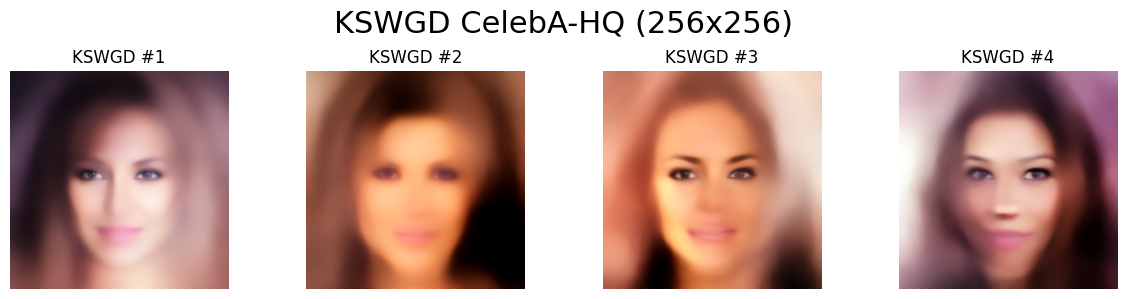


Generation Summary:
  - LDM: 4 images via UNet Denoising (200 steps)
  - KSWGD: 4 images via KSWGD (300 steps)


In [26]:
# Visualize KSWGD generated images (show first 16 of 10000)
n_show = min(16, kswgd_images_np.shape[0])
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axes = np.asarray(axes).reshape(-1)

for idx in range(n_show):
    img = np.transpose(kswgd_images_np[idx], (1, 2, 0))  # (C,H,W) → (H,W,C)
    axes[idx].imshow(np.clip(img, 0.0, 1.0))
    axes[idx].set_title(f"KSWGD #{idx+1}")
    axes[idx].axis('off')

for idx in range(n_show, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f"KSWGD CelebA-HQ (256x256)", fontsize=22)
plt.tight_layout()
plt.show()

print(f"\nGeneration Summary:")
print(f"  - LDM: {len(ldm_generated_images)} images via UNet Denoising (200 steps)")
print(f"  - KSWGD: {kswgd_images_np.shape[0]} images via KSWGD ({kswgd_config['num_iters']} steps)")

Upscaling KSWGD Generated Images with GFPGAN
(with preprocessing: Gaussian + Bilateral + Color Norm)

Enhancing 4 KSWGD images with preprocessing + GFPGAN...


Preprocess+GFPGAN (KSWGD):   0%|          | 0/4 [00:00<?, ?it/s]

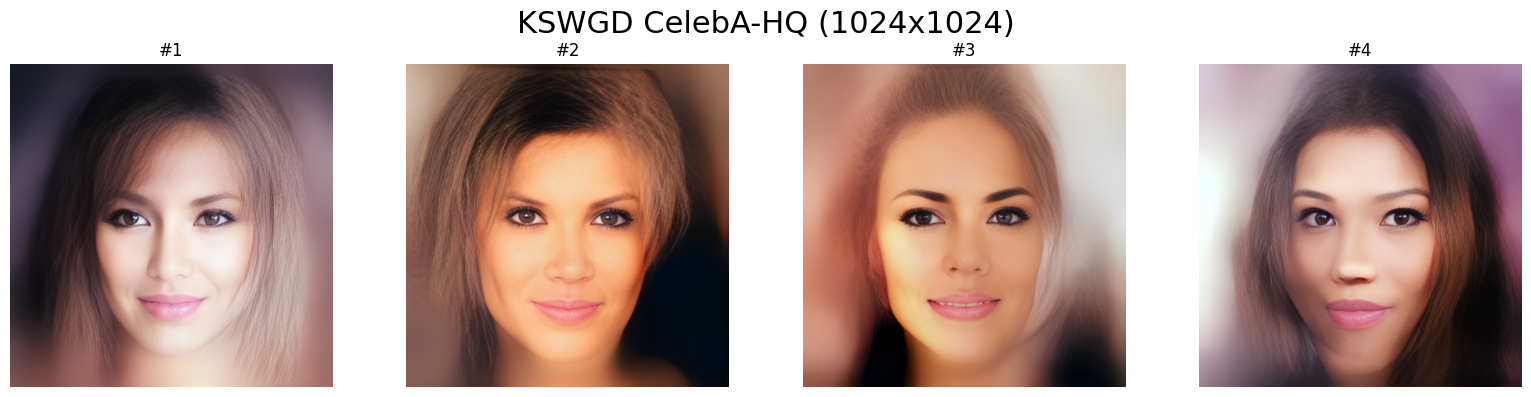


✓ KSWGD Enhancement complete!
  Original KSWGD: 256x256
  Enhanced: 1024x1024
  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)


In [27]:
# ============== Apply GFPGAN to KSWGD Generated Images ==============
print("=" * 60)
print("Upscaling KSWGD Generated Images with GFPGAN")
print("(with preprocessing: Gaussian + Bilateral + Color Norm)")
print("=" * 60)

# Convert KSWGD images to the right format for upscaling
kswgd_images_for_upscale = []
for i in range(kswgd_images_np.shape[0]):
    img = np.transpose(kswgd_images_np[i], (1, 2, 0))  # (C,H,W) → (H,W,C)
    img = np.clip(img, 0, 1)
    kswgd_images_for_upscale.append(img)

print(f"\nEnhancing {len(kswgd_images_for_upscale)} KSWGD images with preprocessing + GFPGAN...")
kswgd_enhanced = upscale_images(kswgd_images_for_upscale, use_face_enhance=True, use_preprocess=True, desc="Preprocess+GFPGAN (KSWGD)")

# Visualization (show up to 16 in a grid)
n_test_kswgd = len(kswgd_enhanced)
n_show_kswgd = min(16, n_test_kswgd)
n_cols = 4
n_rows = (n_show_kswgd + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.asarray(axes).reshape(-1)

for i in range(n_show_kswgd):
    axes[i].imshow(kswgd_enhanced[i])
    axes[i].set_title(f"#{i+1}")
    axes[i].axis('off')

for i in range(n_show_kswgd, len(axes)):
    axes[i].axis('off')

plt.suptitle("KSWGD CelebA-HQ (1024x1024)", fontsize=22)
plt.tight_layout()
plt.savefig('/workspace/kswgd/figures/kswgd_gfpgan_enhanced.png', dpi=150, bbox_inches='tight')
plt.show()

# Store enhanced KSWGD images
kswgd_upscaled = kswgd_enhanced

print(f"\n✓ KSWGD Enhancement complete!")
print(f"  Original KSWGD: 256x256")
print(f"  Enhanced: {kswgd_upscaled[0].shape[1]}x{kswgd_upscaled[0].shape[0]}")
print(f"  Preprocessing applied: Gaussian blur (3x3, σ=0.5) + Bilateral (d=5) + Color norm (α=0.3)")

### 7.2 FID (Fréchet Inception Distance) Evaluation

Compute FID scores to quantitatively compare LDM and KSWGD generation quality.

**FID** measures the distance between the distribution of generated images and real images in Inception-v3 feature space. **Lower is better.**

In [28]:
# ============== FID Utility Functions ==============
# Install pytorch-fid if needed
import subprocess
import sys

try:
    from pytorch_fid import fid_score
    from pytorch_fid.inception import InceptionV3
except ImportError:
    print("Installing pytorch-fid...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-fid", "-q"])
    from pytorch_fid import fid_score
    from pytorch_fid.inception import InceptionV3

from scipy import linalg
from torchvision import transforms as T

def get_inception_features(images, batch_size=32, desc="Extracting features"):
    """
    Extract Inception-v3 features from images.
    Supports:
    - List of PIL images
    - List of numpy arrays (H, W, C) or (C, H, W)
    - Numpy array (N, C, H, W) or (N, H, W, C)
    """
    # Load Inception model
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    inception = InceptionV3([block_idx]).to(device)
    inception.eval()
    
    # Preprocess for Inception (resize to 299x299, normalize)
    preprocess = T.Compose([
        T.Resize((299, 299)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    features_list = []
    n_batches = (len(images) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in tqdm(range(0, len(images), batch_size), total=n_batches, desc=desc):
            batch_samples = images[i:i+batch_size]
            
            tensors = []
            for img in batch_samples:
                if isinstance(img, Image.Image):
                    t = T.ToTensor()(img)
                elif isinstance(img, np.ndarray):
                    t = torch.from_numpy(img).float()
                    if t.ndim == 3:
                        # If (H, W, C), permute to (C, H, W)
                        if t.shape[2] == 3 and t.shape[0] != 3:
                            t = t.permute(2, 0, 1)
                    if t.max() > 1.0: t /= 255.0
                else:
                    t = torch.as_tensor(img).float()
                tensors.append(t)
            
            batch = torch.stack(tensors).to(device)
            batch = preprocess(batch)
            feat = inception(batch)[0]
            feat = feat.squeeze(-1).squeeze(-1)
            features_list.append(feat.cpu().numpy())
    
    del inception
    torch.cuda.empty_cache()
    
    return np.concatenate(features_list, axis=0)

def calculate_fid(real_features, gen_features):
    """Calculate FID between two sets of features"""
    mu_real = np.mean(real_features, axis=0)
    mu_gen = np.mean(gen_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_gen = np.cov(gen_features, rowvar=False)
    
    # Calculate FID
    diff = mu_real - mu_gen
    # Add a small value to diagonal for stability
    offset = np.eye(sigma_real.shape[0]) * 1e-6
    covmean, _ = linalg.sqrtm((sigma_real + offset) @ (sigma_gen + offset), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff @ diff + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return float(fid)

print("✓ FID utility functions defined (with robust numpy handling).")

✓ FID utility functions defined (with robust numpy handling).


In [ ]:
# ============== FID Evaluation (Raw 256x256 Images) ==============
print("=" * 60)
print("Computing FID Scores (on Raw 256x256 Images)...")
print(f"  LDM raw:   {len(ldm_generated_images)} images")
print(f"  KSWGD raw: {len(kswgd_images_np)} images")
print("=" * 60)

# 1. Get real images from CelebA-HQ (resized to 256x256)
n_real_samples = min(2000, len(celebahq_dataset)) 
real_images_256 = []
for i in tqdm(range(n_real_samples), desc="Loading real images (256)"):
    img = celebahq_dataset[i]["image"].resize((256, 256))
    real_images_256.append(np.array(img))

print(f"  Real images loaded: {len(real_images_256)}")

# 2. Extract features
print("\n[1/3] Extracting Inception features from real images (256)...")
real_features_256 = get_inception_features(real_images_256, desc="Real images (256)")

print("\n[2/3] Extracting Inception features from LDM raw images (256)...")
ldm_features_256 = get_inception_features(ldm_generated_images, desc="LDM Raw (256)")

print("\n[3/3] Extracting Inception features from KSWGD raw images (256)...")
kswgd_features_256 = get_inception_features(kswgd_images_np, desc="KSWGD Raw (256)")

# 3. Calculate FID
print("\nCalculating FID scores...")
fid_ldm_raw = calculate_fid(real_features_256, ldm_features_256)
fid_kswgd_raw = calculate_fid(real_features_256, kswgd_features_256)

print("\n" + "=" * 60)
print("FID RESULTS (Raw 256x256, Lower is Better)")
print("=" * 60)
print(f"  Real images:  {n_real_samples}")
print(f"  LDM (Raw):   {len(ldm_generated_images)} → FID = {fid_ldm_raw:.2f}")
print(f"  KSWGD (Raw): {len(kswgd_images_np)} → FID = {fid_kswgd_raw:.2f}")
print("=" * 60)
print(f"\nNote: This FID measures the quality of the raw 256x256 generation before any enhancement.")

Computing FID Scores (on Raw 256x256 Images)...
  LDM raw:   4 images
  KSWGD raw: 4 images


Loading real images (256):   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# ============== FID Evaluation (Enhanced 1024x1024 Images) ==============
print("=" * 60)
print("Computing FID Scores (on 1024x1024 Enhanced Images)...")
print(f"  LDM enhanced:   {len(ldm_upscaled)} images")
print(f"  KSWGD enhanced: {len(kswgd_upscaled)} images")
print("=" * 60)

# 1. Get real images from CelebA-HQ (1024x1024)
print("\n[1/4] Loading real CelebA-HQ images (1024x1024)...")
# Use a smaller number for real images if memory is tight, but 1000-2000 is usually enough for comparison
n_real_samples = min(2000, len(celebahq_dataset)) 
real_images_1024 = []
for i in tqdm(range(n_real_samples), desc="Loading real images (1024)"):
    img = celebahq_dataset[i]["image"]
    # No resize, keep original 1024x1024
    img_tensor = T.ToTensor()(img) 
    real_images_1024.append(img_tensor.numpy())

print(f"  Real images loaded: {len(real_images_1024)}")

print("\n[2/4] Extracting Inception features from real images (1024)...")
real_features_1024 = get_inception_features(real_images_1024, desc="Real images (1024)")

# 2. Get LDM enhanced images features
print("\n[3/4] Extracting Inception features from LDM enhanced images...")
ldm_features_1024 = get_inception_features(ldm_upscaled, desc="LDM Enhanced")

# 3. Get KSWGD enhanced images features  
print("\n[4/4] Extracting Inception features from KSWGD enhanced images...")
kswgd_features_1024 = get_inception_features(kswgd_upscaled, desc="KSWGD Enhanced")

# 4. Calculate FID scores
print("\nCalculating FID scores...")
fid_ldm_enhanced = calculate_fid(real_features_1024, ldm_features_1024)
fid_kswgd_enhanced = calculate_fid(real_features_1024, kswgd_features_1024)

print("\n" + "=" * 60)
print("FID RESULTS (Enhanced 1024x1024, Lower is Better)")
print("=" * 60)
print(f"  Real images:  {n_real_samples}")
print(f"  LDM (Enhanced):   {len(ldm_upscaled)} → FID = {fid_ldm_enhanced:.2f}")
print(f"  KSWGD (Enhanced): {len(kswgd_upscaled)} → FID = {fid_kswgd_enhanced:.2f}")
print("=" * 60)
print(f"\nNote: This FID measures the quality of the full pipeline (Model + Preprocessing + GFPGAN).")

Computing FID Scores (on 1024x1024 Enhanced Images)...
  LDM enhanced:   4 images
  KSWGD enhanced: 4 images

[1/4] Loading real CelebA-HQ images (1024x1024)...


Loading real images (1024):   0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 9. Clean Up GPU Memory

In [ ]:
# Clean up GPU memory
import gc

if 'ldm_pipe' in dir():
    del ldm_pipe
if 'vae' in dir():
    del vae
gc.collect()
torch.cuda.empty_cache()

print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")